# CS273P Final Project

### Group 13: Connor McManigal, Peyton Politewicz, Harold Hin Ng

### Import Libraries and Read in the Data

In [146]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import sklearn
from collections import Counter
import re
from textblob import TextBlob
import vaderSentiment
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk

import ssl

# This will bypass the SSL verification, but it is not safe.
ssl._create_default_https_context = ssl._create_unverified_context

nltk.download('vader_lexicon')

from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans

from sklearn.decomposition import PCA
from matplotlib.patches import Ellipse


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/peytonp/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
df = pd.read_csv("Recipe Reviews and User Feedback Dataset.csv")
df = pd.DataFrame(df)

## Data Cleaning

In [3]:
# Check dataframe shape
df.shape

(18182, 15)

In [4]:
# Drop unneccessary column and check dataframe
df.drop(columns=['Unnamed: 0'], inplace = True)
df = df.dropna()
df.head()

,recipe_number,recipe_code,recipe_name,comment_id,user_id,user_name,user_reputation,created_at,reply_count,thumbs_up,thumbs_down,stars,best_score,text
0,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2G3aneMRgRMZwXqIHmSdXSG1hEM,u_9iFLIhMa8QaG,Jeri326,1,1665619889,0,0,0,5,527,"I tweaked it a little, removed onions because ..."
1,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2FsPC83HtzCsQAtOxlbL6RcaPbY,u_Lu6p25tmE77j,Mark467,50,1665277687,0,7,0,5,724,Bush used to have a white chili bean and it ma...
2,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2FPrSGyTv7PQkZq37j92r9mYGkP,u_s0LwgpZ8Jsqq,Barbara566,10,1664404557,0,3,0,5,710,I have a very complicated white chicken chili ...
3,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2DzdSIgV9qNiuBaLoZ7JQaartoC,u_fqrybAdYjgjG,jeansch123,1,1661787808,2,2,0,0,581,"In your introduction, you mentioned cream chee..."
4,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2DtZJuRQYeTFwXBoZRfRhBPEXjI,u_XXWKwVhKZD69,camper77,10,1664913823,1,7,0,0,820,Wonderful! I made this for a &#34;Chili/Stew&#...


In [5]:
df.shape

(18180, 14)

In [6]:
# Change unix time to date time
df['created_at'] = pd.to_datetime(df['created_at'], unit = 's')

# Check time('created_at') changes and look at unique values
df['created_at'].unique() # returns 2695 unique timestamps

<DatetimeArray>
['2022-10-13 00:11:29', '2022-10-09 01:08:07', '2022-09-28 22:35:57',
 '2022-08-29 15:43:28', '2022-10-04 20:03:43', '2022-08-24 15:19:11',
 '2022-02-05 19:20:05', '2022-02-04 02:35:14', '2022-02-04 00:05:24',
 '2022-01-26 22:57:19',
 ...
 '2022-05-09 18:14:14', '2022-04-08 07:21:21', '2022-03-21 12:27:35',
 '2022-02-11 05:02:10', '2022-02-01 04:29:27', '2022-02-23 22:41:52',
 '2021-08-08 21:44:22', '2021-06-02 15:48:18', '2021-02-11 14:06:47',
 '2021-02-11 09:45:20']
Length: 2695, dtype: datetime64[ns]

In [7]:
df.head()

,recipe_number,recipe_code,recipe_name,comment_id,user_id,user_name,user_reputation,created_at,reply_count,thumbs_up,thumbs_down,stars,best_score,text
0,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2G3aneMRgRMZwXqIHmSdXSG1hEM,u_9iFLIhMa8QaG,Jeri326,1,2022-10-13 00:11:29,0,0,0,5,527,"I tweaked it a little, removed onions because ..."
1,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2FsPC83HtzCsQAtOxlbL6RcaPbY,u_Lu6p25tmE77j,Mark467,50,2022-10-09 01:08:07,0,7,0,5,724,Bush used to have a white chili bean and it ma...
2,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2FPrSGyTv7PQkZq37j92r9mYGkP,u_s0LwgpZ8Jsqq,Barbara566,10,2022-09-28 22:35:57,0,3,0,5,710,I have a very complicated white chicken chili ...
3,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2DzdSIgV9qNiuBaLoZ7JQaartoC,u_fqrybAdYjgjG,jeansch123,1,2022-08-29 15:43:28,2,2,0,0,581,"In your introduction, you mentioned cream chee..."
4,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2DtZJuRQYeTFwXBoZRfRhBPEXjI,u_XXWKwVhKZD69,camper77,10,2022-10-04 20:03:43,1,7,0,0,820,Wonderful! I made this for a &#34;Chili/Stew&#...


## Exploratory Data Analysis

In [8]:
# Check time range of recipe reviews
min = df['created_at'].min()
max = df['created_at'].max()
print(f'Recipe reviews are from "{min}" to "{max}"')

Recipe reviews are from "2021-02-11 09:22:16" to "2022-10-14 14:00:35"


In [9]:
# Find reviews with references
reference_text = df[df['text'].str.contains('&#')]
print(f"{reference_text.shape[0]} reviews reference other previous reviews denoted with '&#'")

6336 reviews reference other previous reviews denoted with '&#'


In [10]:
# Take look at some of the reviews ('text')
df['text'].head()

0    I tweaked it a little, removed onions because ...
1    Bush used to have a white chili bean and it ma...
2    I have a very complicated white chicken chili ...
3    In your introduction, you mentioned cream chee...
4    Wonderful! I made this for a &#34;Chili/Stew&#...
Name: text, dtype: object

In [11]:
# Find min and max length of characters in text
min_length = np.inf
max_length = -np.inf

for text in df['text']:
    text_length = len(text)
    if text_length < min_length:
        min_length = text_length
    if text_length > max_length:
        max_length = text_length

print("Minimum length of characters:", min_length)
print("Maximum length of characters:", max_length)

Minimum length of characters: 1
Maximum length of characters: 2742


In [12]:
# Which texts have length 1?
texts_length_1 = []

for index, text in enumerate(df['text']):
    if len(text) == 1:
        texts_length_1.append((index, text))

if texts_length_1:
    print("Observations with text length of 1:")
    for index, text in texts_length_1:
        print(f"Index: {index}, Text: {text}")
else:
    print("No observations with text length of 1.")

Observations with text length of 1:
Index: 167, Text: .
Index: 252, Text: .
Index: 4282, Text: .
Index: 6014, Text: .
Index: 7556, Text: !
Index: 10048, Text:  
Index: 15047, Text:  
Index: 16062, Text: .


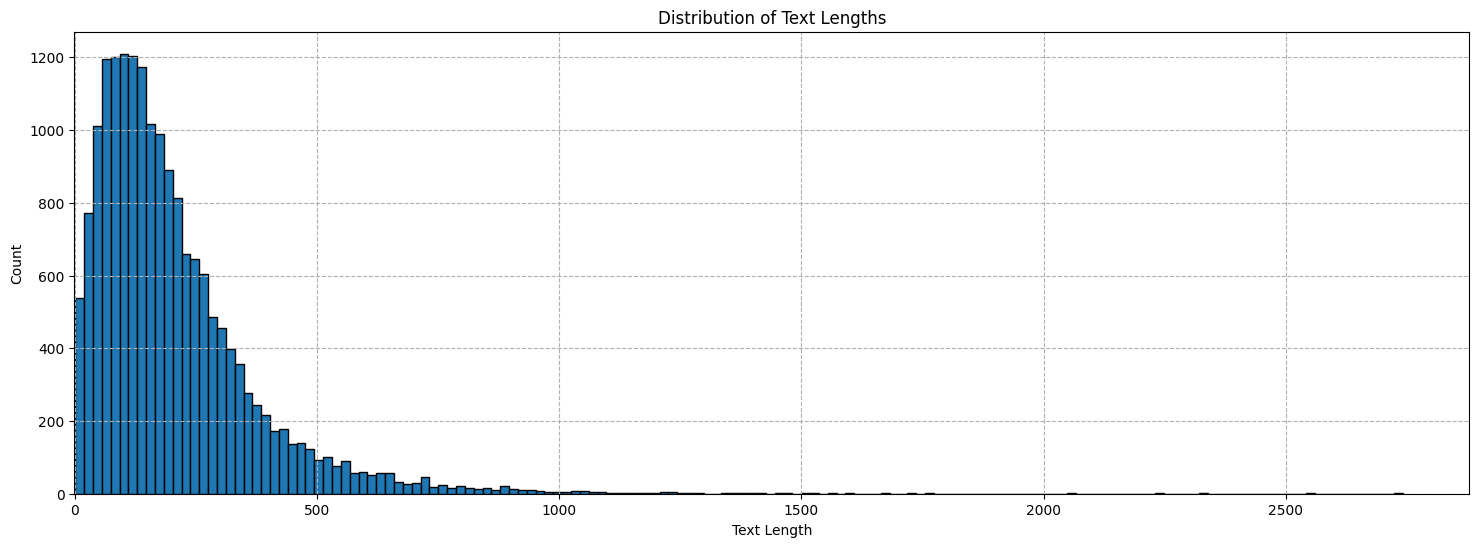

In [13]:
# Plot distribution of text lengths
text_lengths = df['text'].apply(len)

plt.figure(figsize=(18, 6))
plt.hist(text_lengths, bins=150, edgecolor = 'black')
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Count')
plt.xlim(-1)
plt.grid(True, linestyle='--', zorder=1)
plt.show()

In [14]:
# Find 100 most frequent words

all_text = ' '.join(df['text'])
words = re.findall(r'\b\w+\b', all_text.lower())

word_counts = Counter(words)
top_100 = word_counts.most_common(100)
top_100_df = pd.DataFrame(top_100, columns=['Word','Frequency'])

print(top_100_df)

        Word  Frequency
0          i      33614
1        the      29319
2        and      24188
3         it      21929
4          a      17131
..       ...        ...
95       cup       1222
96      from       1218
97      even       1187
98        an       1151
99  everyone       1148

[100 rows x 2 columns]


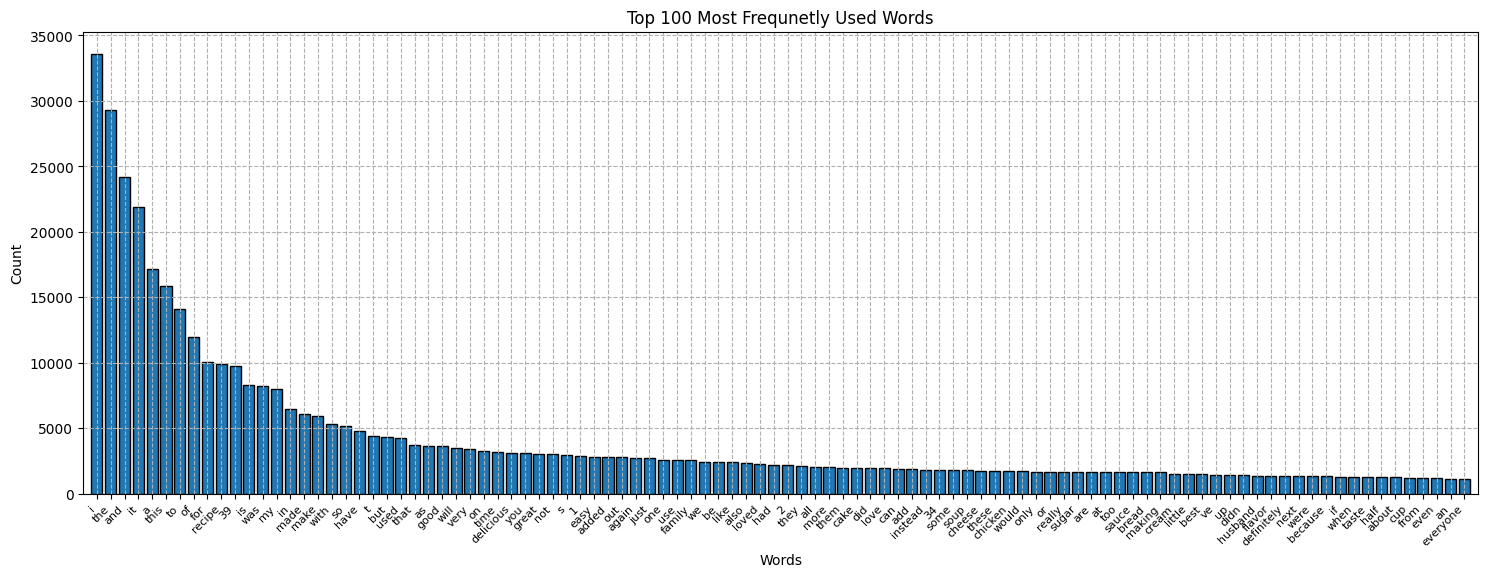

In [15]:
# Plot 100 most frequent words
top_100_words = dict(word_counts.most_common(100))
x = np.arange(len(top_100_words))

plt.figure(figsize=(18, 6))
plt.bar(x, top_100_words.values(), edgecolor = 'black')
plt.title('Top 100 Most Frequnetly Used Words')
plt.xlabel('Words')
plt.ylabel('Count')
plt.xticks(x, top_100_words.keys(), rotation=45, ha='right', fontsize=8)
plt.xlim(-1, 100)
plt.grid(True, linestyle='--', zorder=1)
plt.show()

In [16]:
# Explore descriptive statistics of user reputations
df['user_reputation'].describe()

count    18180.000000
mean         2.159736
std         10.015210
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max        520.000000
Name: user_reputation, dtype: float64

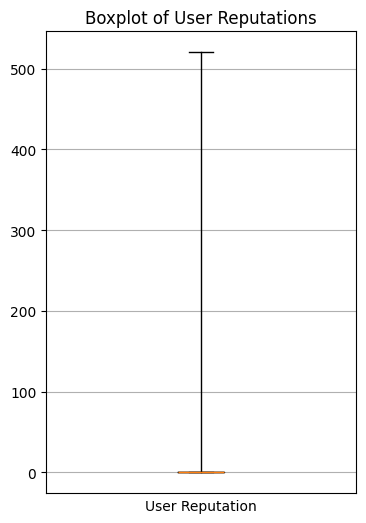

In [17]:
# Plot boxplot of user reputations
plt.figure(figsize=(4,6))
plt.boxplot(df['user_reputation'].values, whis = (0, 100))
plt.xticks([])
plt.title('Boxplot of User Reputations')
plt.xlabel('User Reputation')
plt.grid(True)
plt.show()

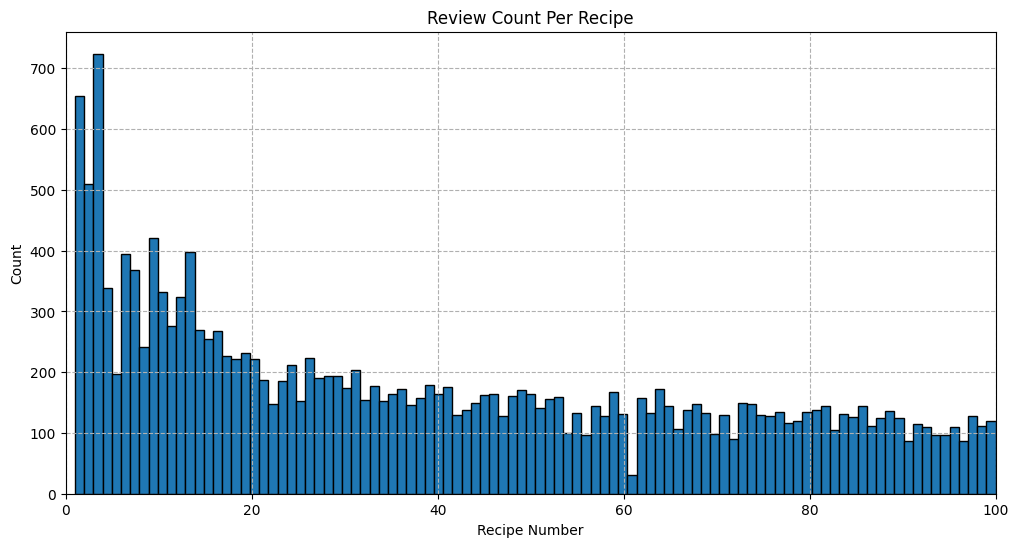

In [18]:
# Plot counts of number of reviews per recipe
plt.figure(figsize = (12,6))
plt.hist(df['recipe_number'], bins = 100, edgecolor = 'black')
plt.title('Review Count Per Recipe')
plt.xlabel('Recipe Number')
plt.ylabel('Count')
plt.xlim(0,100)
plt.grid(True, linestyle='--', zorder=0)
plt.show()

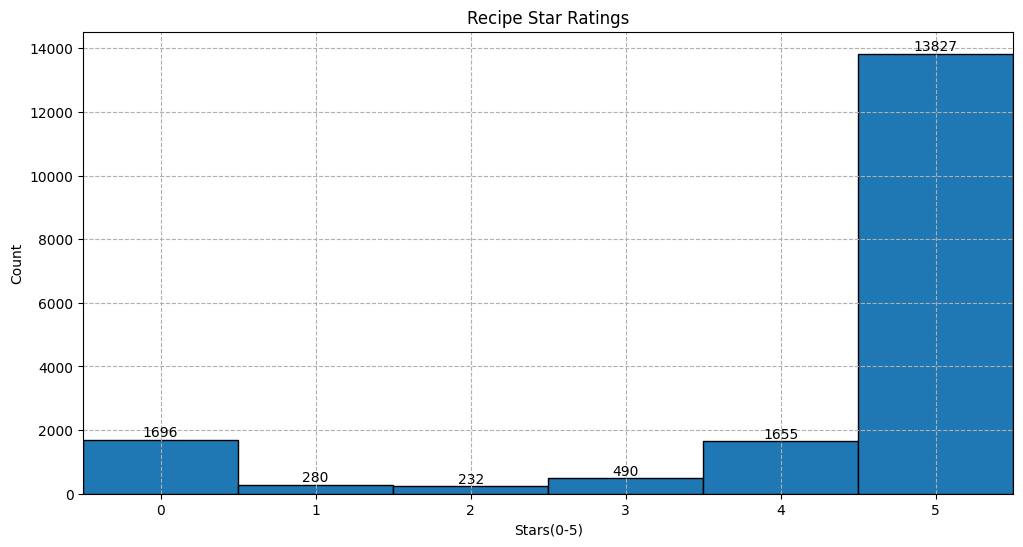

In [19]:
# Check distribution of recipe star ratings
bin_edges = np.arange(-0.5, 6.5, 1)

plt.figure(figsize=(12,6))
counts, bins, _ = plt.hist(df['stars'], bins = bin_edges, edgecolor = 'black', zorder=0)

# Add annotations at the top of each bin
for count, bin_edge in zip(counts, bins[:-1]):
    plt.text(bin_edge + 0.5, count, str(int(count)), ha='center', va='bottom')

plt.title('Recipe Star Ratings')
plt.xlabel('Stars(0-5)')
plt.ylabel('Count')
plt.xlim(-0.5,5.5)
plt.grid(True, linestyle='--', zorder=1)
plt.show()

In [20]:
df[df['user_name'] == 'Mark467']

,recipe_number,recipe_code,recipe_name,comment_id,user_id,user_name,user_reputation,created_at,reply_count,thumbs_up,thumbs_down,stars,best_score,text
1,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2FsPC83HtzCsQAtOxlbL6RcaPbY,u_Lu6p25tmE77j,Mark467,50,2022-10-09 01:08:07,0,7,0,5,724,Bush used to have a white chili bean and it ma...


In [50]:
pol_list1 = []
pol_list2 = []
sub_list = []
sid_obj = SentimentIntensityAnalyzer()


for row in df.iloc[:, 13]:
    temp = TextBlob(row)
    sent_dict = sid_obj.polarity_scores(row)
    pol_list1.append(sent_dict['compound'])
    pol_list2.append(temp.sentiment.polarity)
    sub_list.append(temp.sentiment.subjectivity)


df2 = df.assign(polarity_from_vader = pol_list1)
df2 = df2.assign(polarity_from_blob = pol_list2)

pol_list1 = np.array(pol_list1)
pol_list2 = np.array(pol_list2)
temp_diff_btw_vader_and_blob = np.subtract(pol_list1, pol_list2)
diff_btw_vader_and_blob = temp_diff_btw_vader_and_blob.tolist()
df2 = df2.assign(diff_in_polarity_scores = diff_btw_vader_and_blob)
df2 = df2.assign(subjectivity = sub_list)

df2.head()

,recipe_number,recipe_code,recipe_name,comment_id,user_id,user_name,user_reputation,created_at,reply_count,thumbs_up,thumbs_down,stars,best_score,text,polarity_from_vader,polarity_from_blob,diff_in_polarity_scores,subjectivity
0,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2G3aneMRgRMZwXqIHmSdXSG1hEM,u_9iFLIhMa8QaG,Jeri326,1,2022-10-13 00:11:29,0,0,0,5,527,"I tweaked it a little, removed onions because ...",0.8881,0.306481,0.581619,0.598148
1,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2FsPC83HtzCsQAtOxlbL6RcaPbY,u_Lu6p25tmE77j,Mark467,50,2022-10-09 01:08:07,0,7,0,5,724,Bush used to have a white chili bean and it ma...,0.6360,0.083333,0.552667,0.255952
2,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2FPrSGyTv7PQkZq37j92r9mYGkP,u_s0LwgpZ8Jsqq,Barbara566,10,2022-09-28 22:35:57,0,3,0,5,710,I have a very complicated white chicken chili ...,0.9437,0.129861,0.813839,0.525000
3,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2DzdSIgV9qNiuBaLoZ7JQaartoC,u_fqrybAdYjgjG,jeansch123,1,2022-08-29 15:43:28,2,2,0,0,581,"In your introduction, you mentioned cream chee...",0.0000,0.000000,0.000000,0.000000
4,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2DtZJuRQYeTFwXBoZRfRhBPEXjI,u_XXWKwVhKZD69,camper77,10,2022-10-04 20:03:43,1,7,0,0,820,Wonderful! I made this for a &#34;Chili/Stew&#...,0.6114,0.233333,0.378067,0.816667


In [132]:
df2['votescore'] = df2['thumbs_up'] - df2['thumbs_down']
df2 = df2.reset_index(drop = True)

In [144]:
print(df2['votescore'].idxmin())
df2.iloc[9754, 13]

9754


'Maybe I&#39;m a little prejudiced but I have trouble trusting a recipe that uses a spice MIX. What&#39;s up with that? How difficut is it to shake out the cumin and corriander?'

In [135]:
df2[df2['best_score'] == 946]

,recipe_number,recipe_code,recipe_name,comment_id,user_id,user_name,user_reputation,created_at,reply_count,thumbs_up,thumbs_down,stars,best_score,text,polarity_from_vader,polarity_from_blob,diff_in_polarity_scores,subjectivity,votescore
9756,37,20170,Taco Lasagna,sp_aUSaElGf_20170_c_1xZvP3lT0IAJGAbyyU9EQBjHl0O,u_IvqsrnOAh4bF,CYNTHIA534,1,2021-09-02 09:36:37,1,42,0,5,946,"With only 2 of us at home now, I make this usi...",0.6114,0.175,0.4364,0.455556,42


In [153]:
dfAlgoComments = df2[df2['best_score'] > 100].copy()
dfAlgoUsers = df2[df2['user_reputation'] != 1].copy()
dfAlgoComments['comment_length'] = dfAlgoComments['text'].str.len()
dfAlgoUsers['comment_length'] = dfAlgoUsers['text'].str.len()



In [154]:
print(dfAlgoComments['comment_length'].describe())
print(dfAlgoUsers['comment_length'].describe())



count    4165.000000
mean      257.992797
std       208.991023
min         4.000000
25%       117.000000
50%       212.000000
75%       334.000000
max      2548.000000
Name: comment_length, dtype: float64
count    1246.000000
mean      233.450241
std       196.387173
min         2.000000
25%       110.000000
50%       190.000000
75%       298.000000
max      2322.000000
Name: comment_length, dtype: float64


In [137]:
print(dfAlgoComments['best_score'].describe())
print(dfAlgoComments['user_reputation'].describe())
print(dfAlgoComments['thumbs_down'].describe())

count    4165.000000
mean      332.366387
std       212.613947
min       101.000000
25%       193.000000
50%       240.000000
75%       395.000000
max       946.000000
Name: best_score, dtype: float64
count    4165.000000
mean        3.933974
std        19.908212
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max       520.000000
Name: user_reputation, dtype: float64
count    4165.000000
mean        1.967827
std         6.374098
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max       122.000000
Name: thumbs_down, dtype: float64


In [138]:
print(dfAlgoUsers['best_score'].describe())
print(dfAlgoUsers['user_reputation'].describe())

count    1246.000000
mean      223.271268
std       199.913625
min         0.000000
25%       100.000000
50%       100.000000
75%       258.000000
max       934.000000
Name: best_score, dtype: float64
count    1246.000000
mean       17.921348
std        34.607568
min         0.000000
25%        10.000000
50%        10.000000
75%        20.000000
max       520.000000
Name: user_reputation, dtype: float64


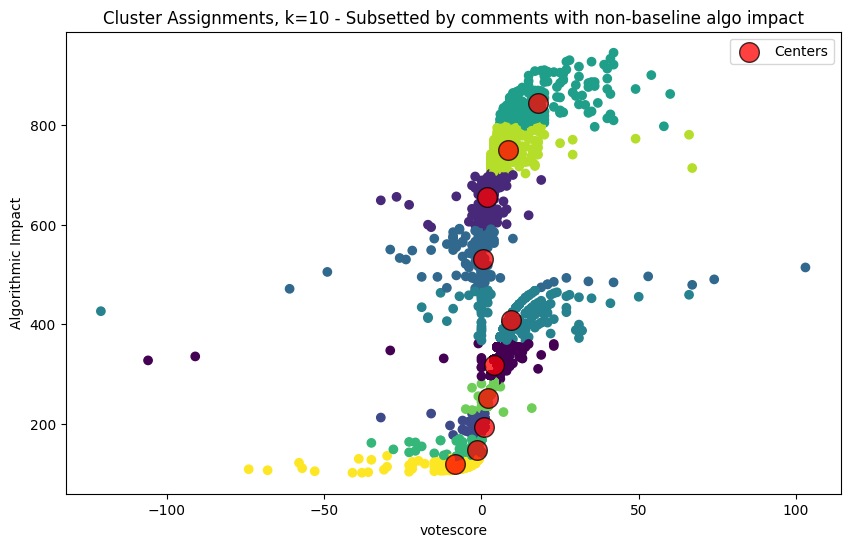

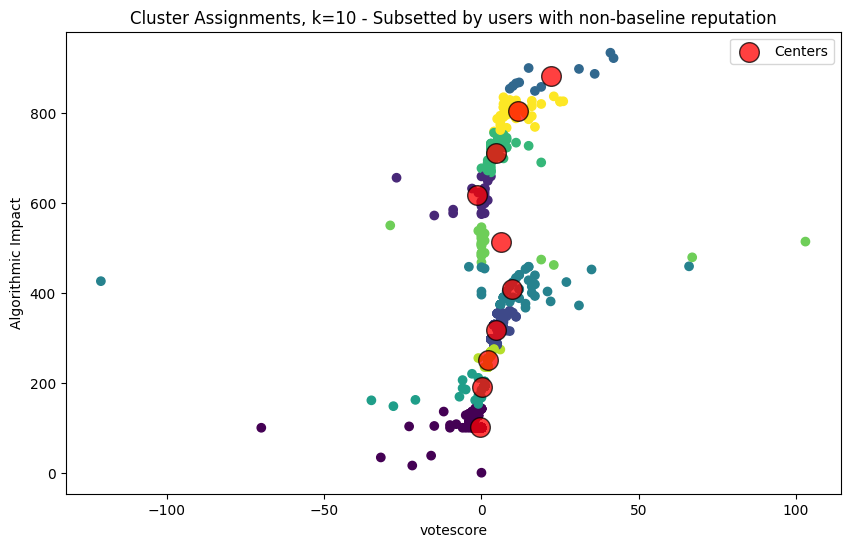

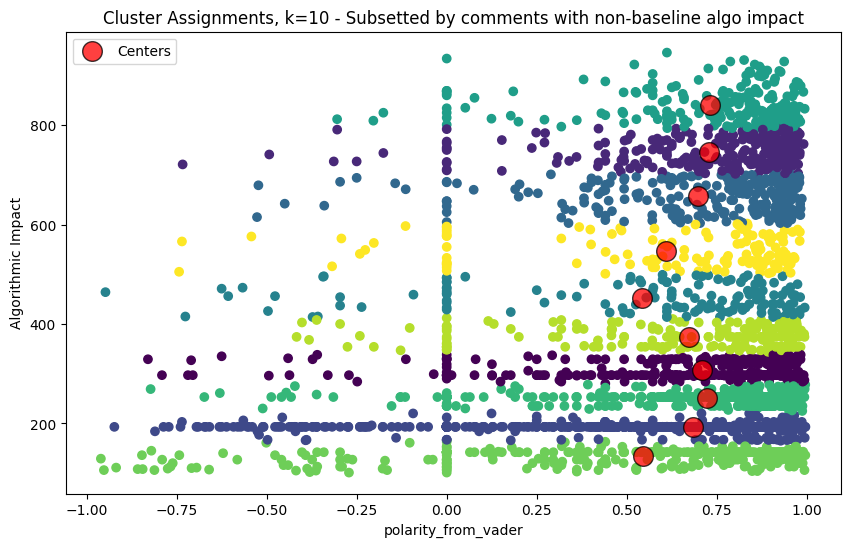

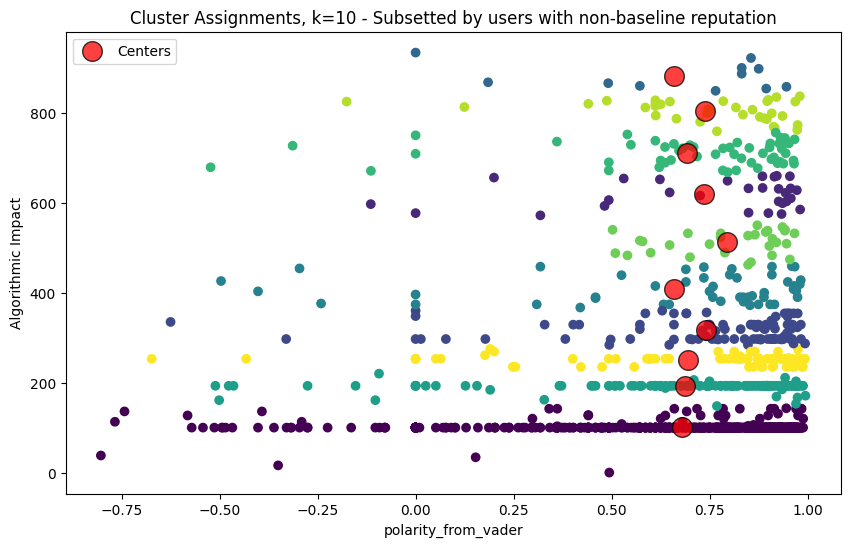

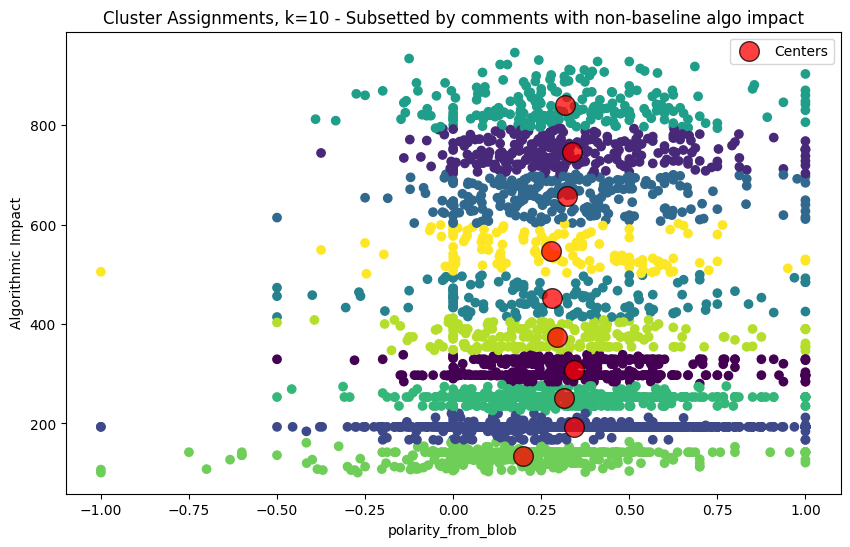

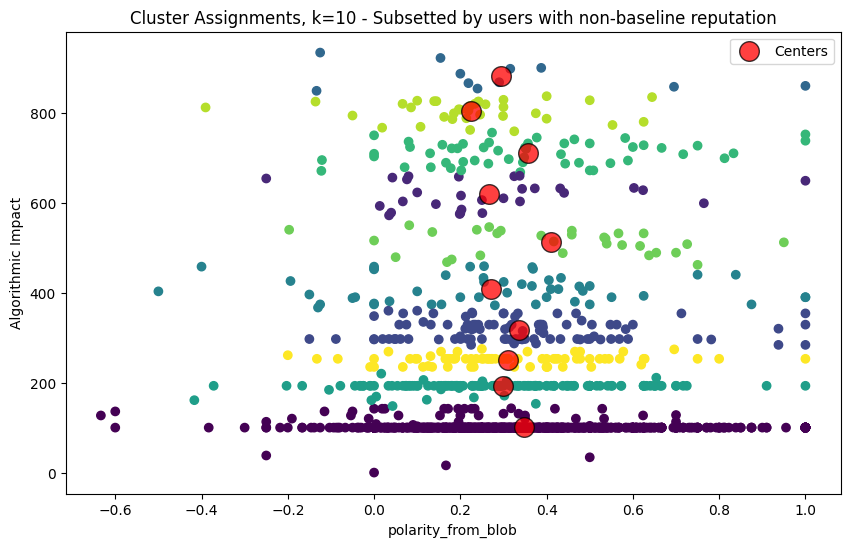

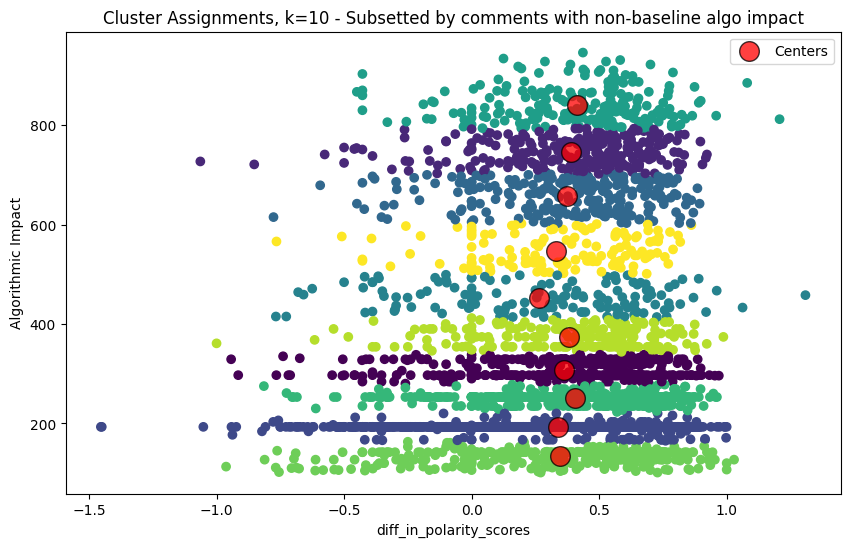

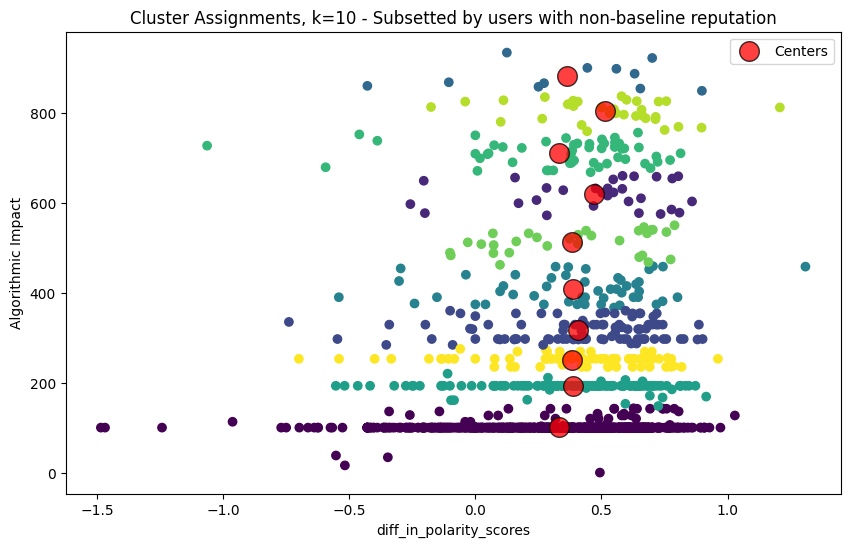

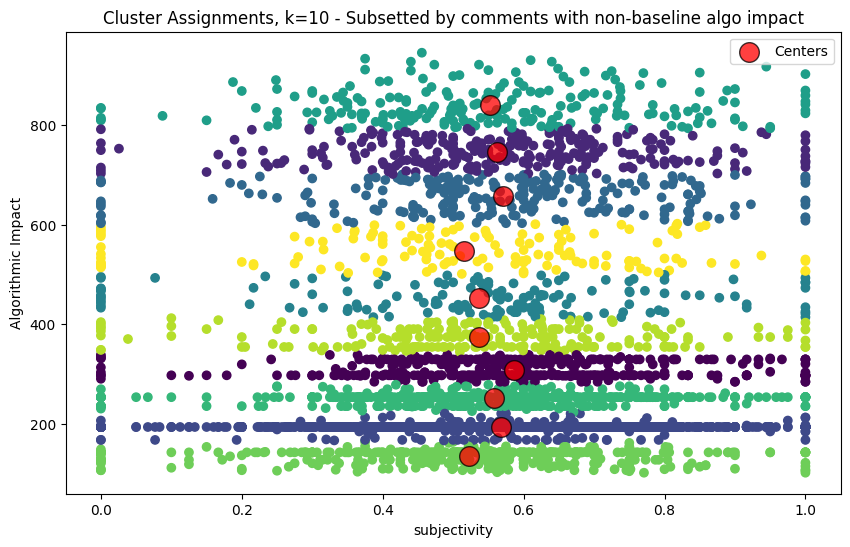

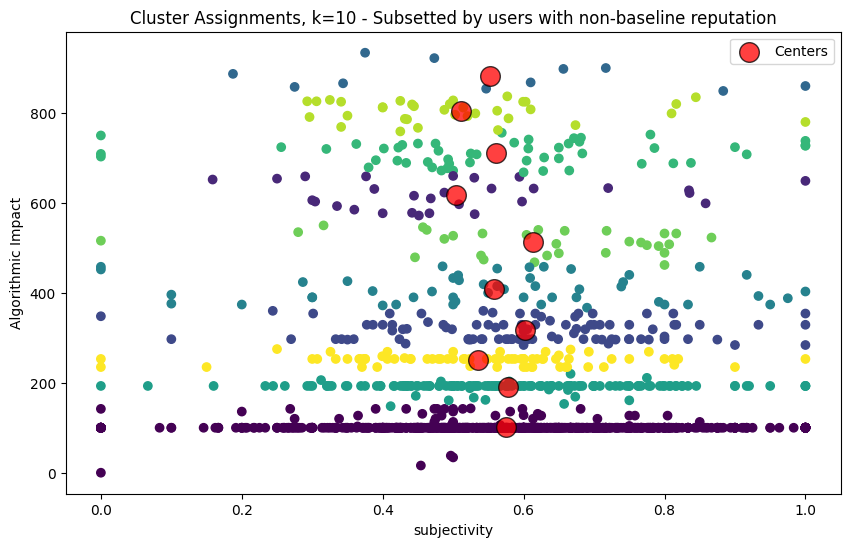

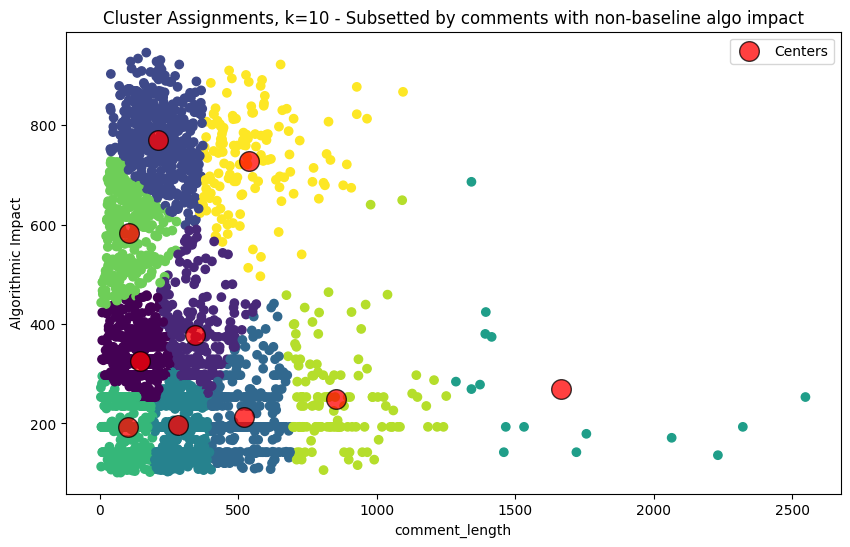

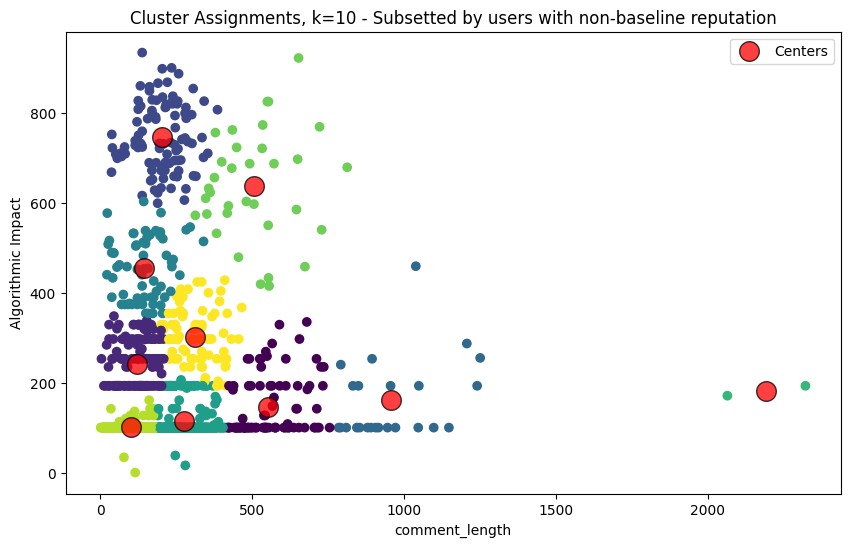

In [158]:
toTest = ['votescore', 'polarity_from_vader', 'polarity_from_blob', 'diff_in_polarity_scores', 'subjectivity', 'comment_length']
for param in toTest:

    kmeansDF = dfAlgoComments[[param, 'best_score']].copy()

    kmeans = KMeans(n_clusters = 10, random_state = 0, n_init = "auto").fit(kmeansDF)

    # Assigning the cluster centers
    kmeansDF['cluster'] = kmeans.labels_

    # Plotting the clusters
    plt.figure(figsize=(10, 6))

    # Scatter plot of the data with color-coding for clusters
    plt.scatter(kmeansDF[param], kmeansDF['best_score'], c=kmeansDF['cluster'], cmap='viridis')

    # Optionally, you can also plot the cluster centers
    centers = kmeans.cluster_centers_
    plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.75, marker='o', edgecolors='black', label='Centers')

    plt.title('Cluster Assignments, k=10 - Subsetted by comments with non-baseline algo impact')
    plt.xlabel(param)
    plt.ylabel('Algorithmic Impact')
    plt.legend(loc='best')
    plt.show()

    kmeansDF = dfAlgoUsers[[param, 'best_score']].copy()

    kmeans = KMeans(n_clusters = 10, random_state = 0, n_init = "auto").fit(kmeansDF)

    # Assigning the cluster centers
    kmeansDF['cluster'] = kmeans.labels_

    # Plotting the clusters
    plt.figure(figsize=(10, 6))

    # Scatter plot of the data with color-coding for clusters
    plt.scatter(kmeansDF[param], kmeansDF['best_score'], c=kmeansDF['cluster'], cmap='viridis')

    # Optionally, you can also plot the cluster centers
    centers = kmeans.cluster_centers_
    plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.75, marker='o', edgecolors='black', label='Centers')

    plt.title('Cluster Assignments, k=10 - Subsetted by users with non-baseline reputation')
    plt.xlabel(param)
    plt.ylabel('Algorithmic Impact')
    plt.legend(loc='best')
    plt.show()

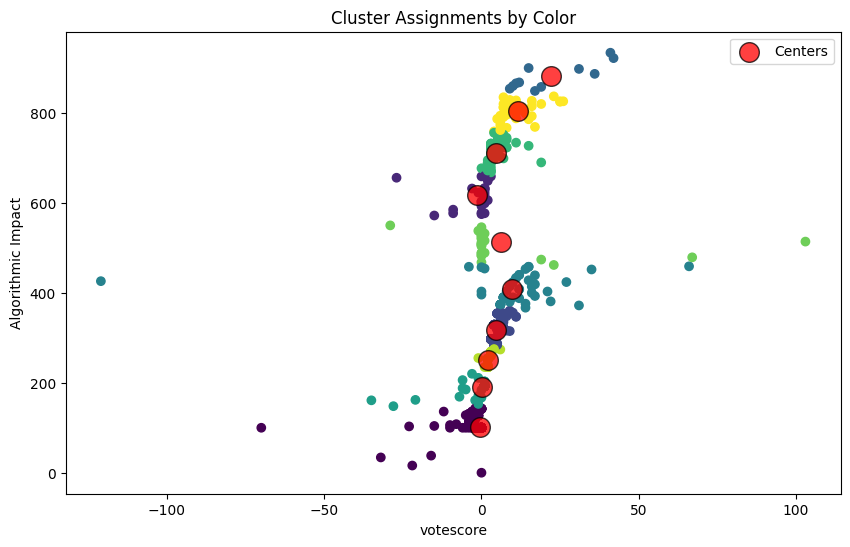

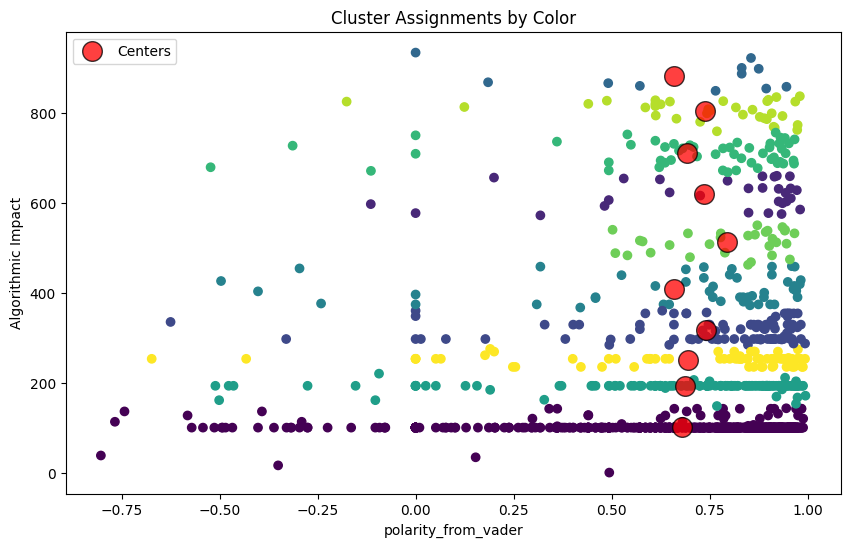

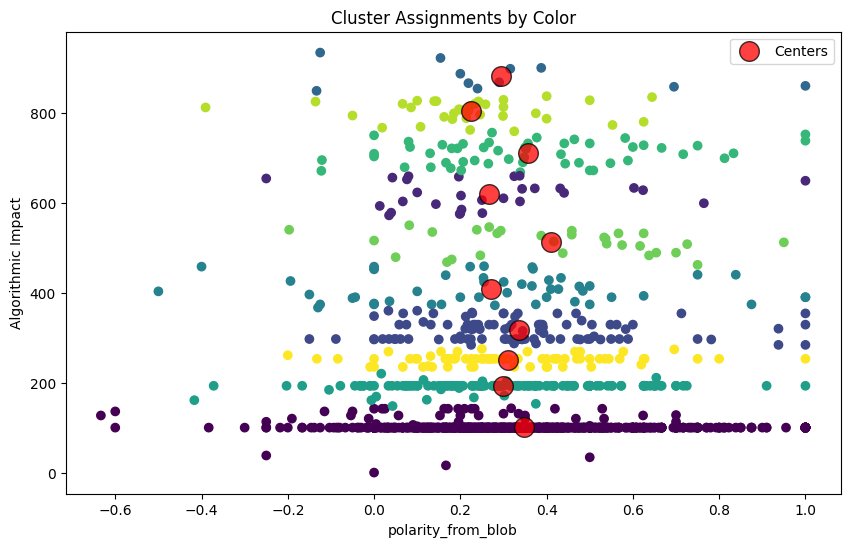

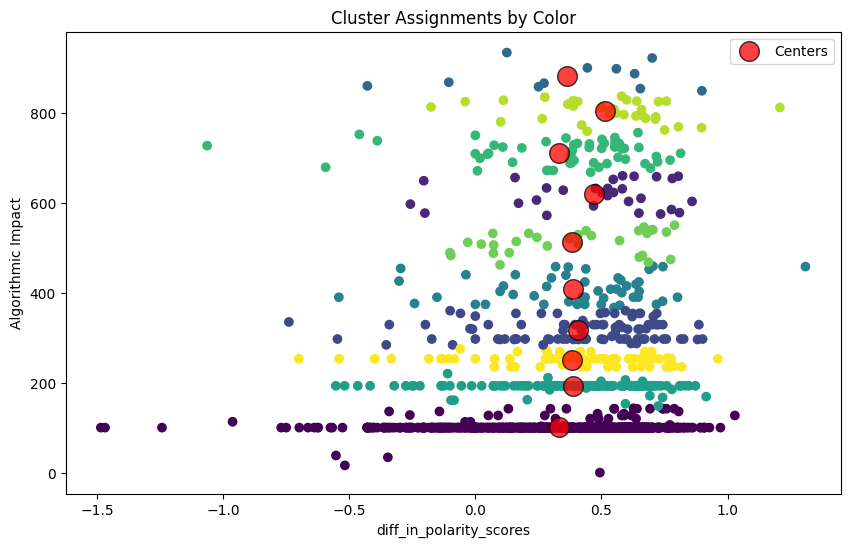

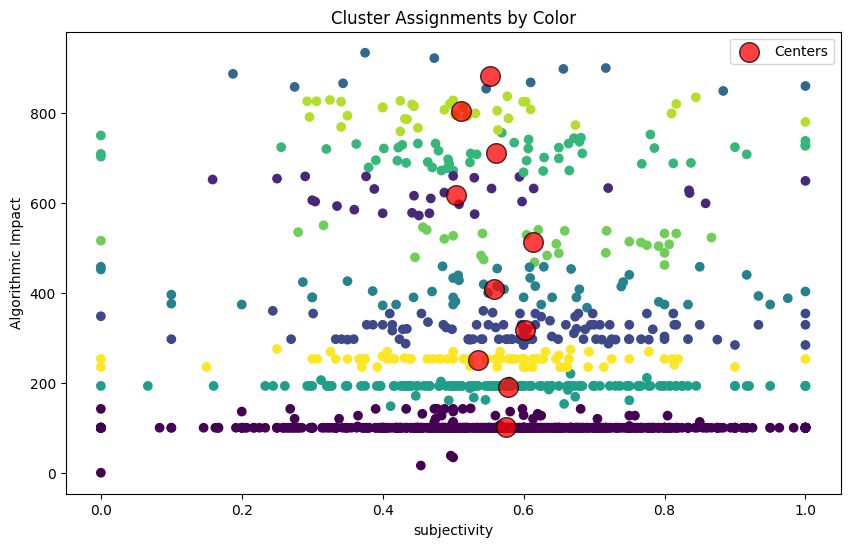

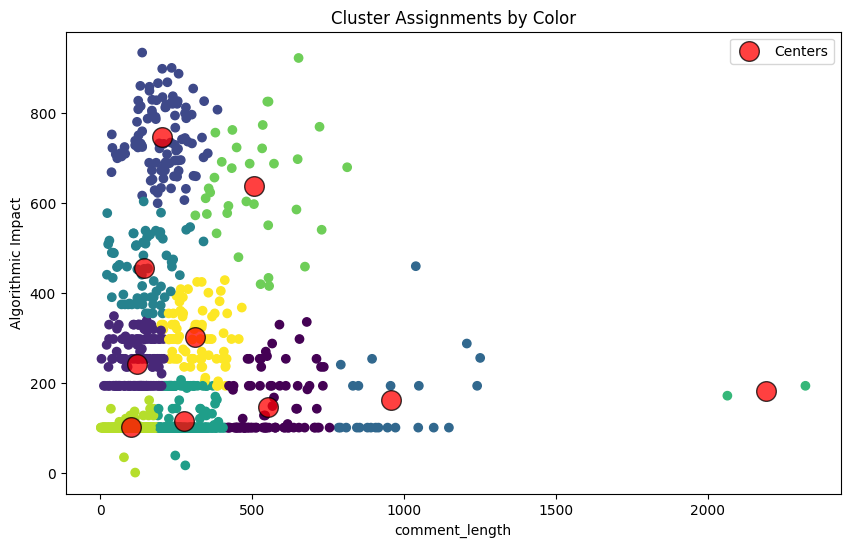

In [156]:
toTest = ['votescore', 'polarity_from_vader', 'polarity_from_blob', 'diff_in_polarity_scores', 'subjectivity', 'comment_length']
for param in toTest:

    kmeansDF = dfAlgoComments[[param, 'best_score']].copy()


    kmeans = KMeans(n_clusters = 10, random_state = 0, n_init = "auto").fit(kmeansDF)

    # Assigning the cluster centers
    kmeansDF['cluster'] = kmeans.labels_

    # Plotting the clusters
    plt.figure(figsize=(10, 6))

    # Scatter plot of the data with color-coding for clusters
    plt.scatter(kmeansDF[param], kmeansDF['best_score'], c=kmeansDF['cluster'], cmap='viridis')

    # Optionally, you can also plot the cluster centers
    centers = kmeans.cluster_centers_
    plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.75, marker='o', edgecolors='black', label='Centers')

    plt.title('Cluster Assignments by Color')
    plt.xlabel(param)
    plt.ylabel('Algorithmic Impact')
    plt.legend(loc='best')
    plt.show()
    
    kmeansDF = dfAlgoUsers[[param, 'best_score']].copy()


    kmeans = KMeans(n_clusters = 10, random_state = 0, n_init = "auto").fit(kmeansDF)

    # Assigning the cluster centers
    kmeansDF['cluster'] = kmeans.labels_

    # Plotting the clusters
    plt.figure(figsize=(10, 6))

    # Scatter plot of the data with color-coding for clusters
    plt.scatter(kmeansDF[param], kmeansDF['best_score'], c=kmeansDF['cluster'], cmap='viridis')

    # Optionally, you can also plot the cluster centers
    centers = kmeans.cluster_centers_
    plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.75, marker='o', edgecolors='black', label='Centers')

    plt.title('Cluster Assignments by Color')
    plt.xlabel(param)
    plt.ylabel('Algorithmic Impact')
    plt.legend(loc='best')
    plt.show()